# Load and Inspect Data

In [1]:
import pandas as pd

# Load the dataset from GitHub
csv_url = "https://raw.githubusercontent.com/xyzesther/decoding_digital_personas/main/data/mbti_1.csv"
df = pd.read_csv(csv_url)

print(f"Dataset shape: {df.shape}\n")

df.head()

# Remove missing values and reset index
df = df.dropna().reset_index(drop=True)

# Display unique MBTI types
print("Unique MBTI Types:\n", df['type'].unique())

Dataset shape: (8675, 2)

Unique MBTI Types:
 ['INFJ' 'ENTP' 'INTP' 'INTJ' 'ENTJ' 'ENFJ' 'INFP' 'ENFP' 'ISFP' 'ISTP'
 'ISFJ' 'ISTJ' 'ESTP' 'ESFP' 'ESTJ' 'ESFJ']


### Distribution of the data

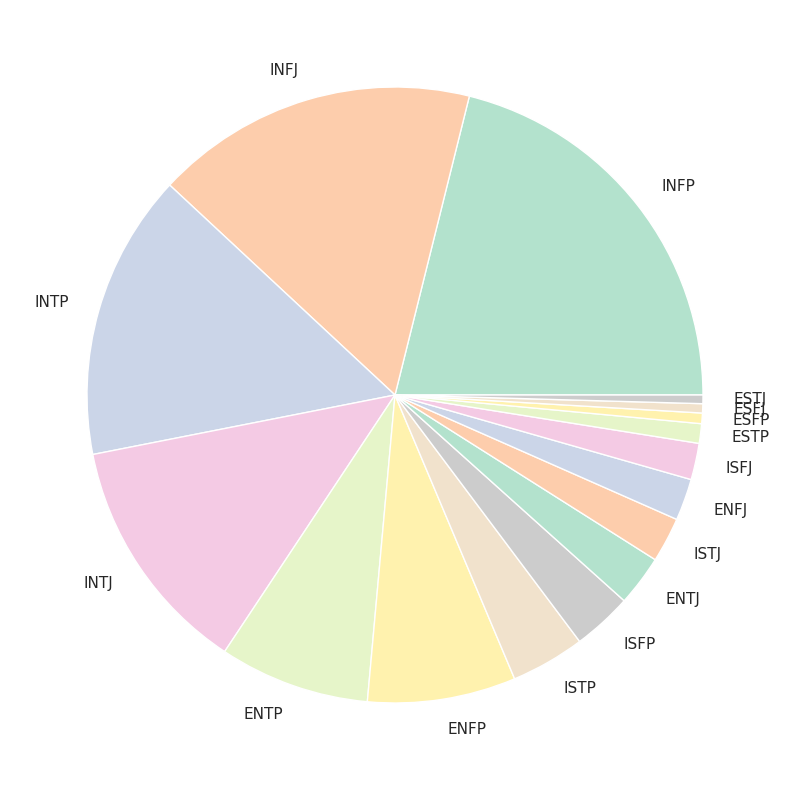

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of MBTI types
mbti_dict = df['type'].value_counts().to_dict()
mbti = list(mbti_dict.keys())
vals = list(mbti_dict.values())

sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize = (10,10))
plt.pie(vals, labels = mbti, colors = plt.cm.Pastel2.colors)
plt.show()

#### Distribution By MBTI Traits

In [3]:
# Convert MBTI labels into four binary features (E/I, S/N, T/F, J/P)
def mbti_to_binary(mbti_type):
    return [
        1 if mbti_type[0] == 'E' else 0,
        1 if mbti_type[1] == 'S' else 0,
        1 if mbti_type[2] == 'T' else 0,
        1 if mbti_type[3] == 'J' else 0
    ]

df[['E/I', 'S/N', 'T/F', 'J/P']] = df['type'].apply(lambda x: pd.Series(mbti_to_binary(x)))

df.head()


,type,posts,E/I,S/N,T/F,J/P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,1


In [4]:
print(df["E/I"].value_counts())
print(df["S/N"].value_counts())
print(df["T/F"].value_counts())
print(df["J/P"].value_counts())

E/I
0    6676
1    1999
Name: count, dtype: int64
S/N
0    7478
1    1197
Name: count, dtype: int64
T/F
0    4694
1    3981
Name: count, dtype: int64
J/P
0    5241
1    3434
Name: count, dtype: int64


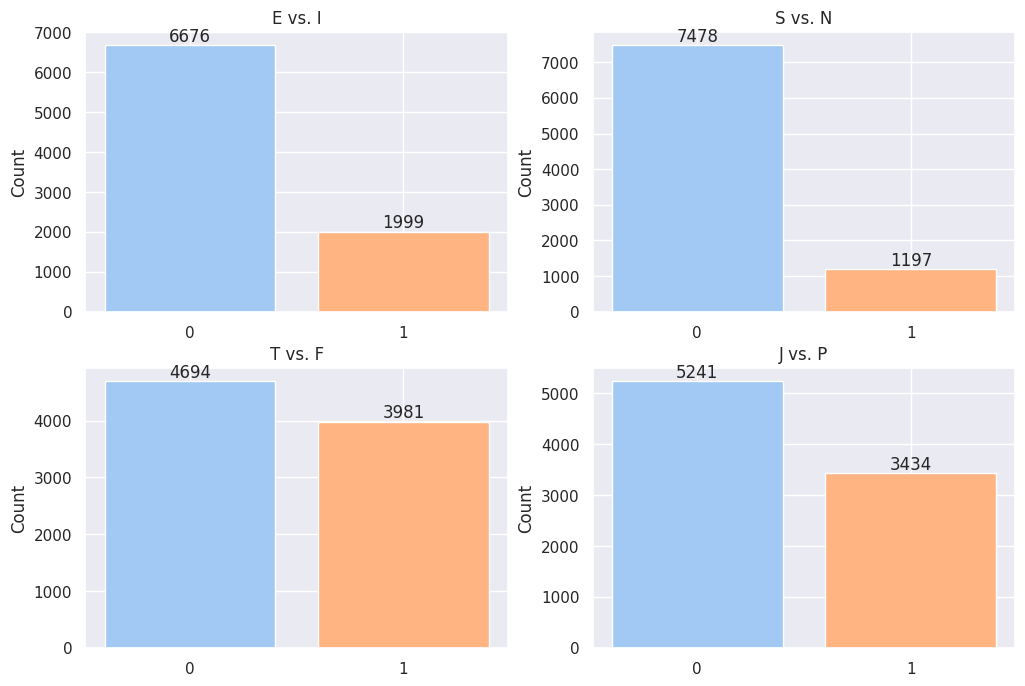

In [5]:
# Show the trait distribution in histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
colors = sns.color_palette("pastel")

def bar_plot(colors, ax, title, col):
    bars = ax.bar(x = df[col].value_counts().index,
           height=df[col].value_counts().values,
           color=colors,
           tick_label = df[col].value_counts().index)
    ax.set_title(title)
    ax.set_ylabel("Count")

    for bar in bars:
      height = bar.get_height()
      ax.text(bar.get_x() + bar.get_width() / 2, height,
              int(height),
              ha="center", va="bottom")

bar_plot(colors, axs[0][0], "E vs. I", "E/I" )
bar_plot(colors, axs[0][1], "S vs. N", "S/N" )
bar_plot(colors, axs[1][0], "T vs. F", "T/F")
bar_plot(colors, axs[1][1], "J vs. P", "J/P")

# Use BERT + MLP model

In [8]:
# Join the 50 posts into one text string and remove URLs
import re

def clean_and_join(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    return " ".join(text.split("|||"))

def mbti_to_binary(mbti_type):
    return [
        1 if mbti_type[0] == 'E' else 0,
        1 if mbti_type[1] == 'S' else 0,
        1 if mbti_type[2] == 'T' else 0,
        1 if mbti_type[3] == 'J' else 0
    ]

df["clean_text_bert"] = df["posts"].apply(clean_and_join)
df["labels"] = df["type"].apply(mbti_to_binary)

In [9]:
from sklearn.model_selection import train_test_split

# Split data
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["clean_text_bert"].tolist(), df["labels"].tolist(), test_size=0.25, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

In [10]:
# Dataset class
from torch.utils.data import Dataset, DataLoader

class MBTIDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, return_tensors="pt", max_length=self.max_len,
                                padding="max_length", truncation=True)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return inputs["input_ids"], inputs["attention_mask"], label

    def __len__(self):
        return len(self.texts)


In [11]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel

# BERT + MLP model
class BertMLPClassifier(nn.Module):
    def __init__(self, pretrained_model="bert-base-uncased"):
        super(BertMLPClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model)
        self.classifier = nn.Sequential(
            nn.Linear(768, 50),
            nn.ReLU(),
            nn.Linear(50, 4)  # 4 MBTI binary traits
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        return self.classifier(cls_output)

In [13]:
# Prepare data loaders and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = MBTIDataset(train_texts, train_labels, tokenizer)
val_dataset = MBTIDataset(val_texts, val_labels, tokenizer)
test_dataset = MBTIDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
model = BertMLPClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

Using cuda device


In [15]:
import numpy as np

# Compute pos_weight to handle label imbalance
y_array = np.array(train_labels)
pos_weights = torch.tensor([(len(y_array) / y_array[:, i].sum()) for i in range(4)]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

In [16]:
# Learning rate scheduler with warmup + decay
from transformers import get_linear_schedule_with_warmup

epochs = 10
patience = 3  # for early stopping
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

In [17]:
from tqdm import tqdm

# Train the model with early stopping
best_loss = float('inf')
patience_counter = 0
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, (input_ids, attention_mask, labels) in enumerate(tqdm(train_loader)):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        if step % 50 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch+1}, Step {step}: LR = {current_lr:.8f}")

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1} | Avg Loss: {avg_loss:.4f}")

    # early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


  0%|          | 1/407 [00:01<09:00,  1.33s/it]

Epoch 1, Step 0: LR = 0.00000005


 12%|█▏        | 50/407 [00:49<05:46,  1.03it/s]

Epoch 1, Step 50: LR = 0.00000251


 25%|██▍       | 100/407 [01:37<04:57,  1.03it/s]

Epoch 1, Step 100: LR = 0.00000496


 37%|███▋      | 150/407 [02:26<04:08,  1.03it/s]

Epoch 1, Step 150: LR = 0.00000742


 49%|████▉     | 200/407 [03:14<03:20,  1.03it/s]

Epoch 1, Step 200: LR = 0.00000988


 61%|██████▏   | 250/407 [04:03<02:30,  1.04it/s]

Epoch 1, Step 250: LR = 0.00001233


 74%|███████▎  | 300/407 [04:51<01:44,  1.02it/s]

Epoch 1, Step 300: LR = 0.00001479


 86%|████████▌ | 350/407 [05:40<00:55,  1.03it/s]

Epoch 1, Step 350: LR = 0.00001725


 98%|█████████▊| 400/407 [06:28<00:06,  1.04it/s]

Epoch 1, Step 400: LR = 0.00001971


100%|██████████| 407/407 [06:34<00:00,  1.03it/s]


Epoch 1 | Avg Loss: 1.1355


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch 2, Step 0: LR = 0.00001999


 12%|█▏        | 50/407 [00:48<05:45,  1.03it/s]

Epoch 2, Step 50: LR = 0.00001972


 25%|██▍       | 100/407 [01:36<04:50,  1.06it/s]

Epoch 2, Step 100: LR = 0.00001945


 37%|███▋      | 150/407 [02:25<04:08,  1.04it/s]

Epoch 2, Step 150: LR = 0.00001918


 49%|████▉     | 200/407 [03:13<03:19,  1.04it/s]

Epoch 2, Step 200: LR = 0.00001890


 61%|██████▏   | 250/407 [04:01<02:31,  1.03it/s]

Epoch 2, Step 250: LR = 0.00001863


 74%|███████▎  | 300/407 [04:50<01:44,  1.03it/s]

Epoch 2, Step 300: LR = 0.00001836


 86%|████████▌ | 350/407 [05:39<00:55,  1.03it/s]

Epoch 2, Step 350: LR = 0.00001808


 98%|█████████▊| 400/407 [06:27<00:06,  1.03it/s]

Epoch 2, Step 400: LR = 0.00001781


100%|██████████| 407/407 [06:34<00:00,  1.03it/s]


Epoch 2 | Avg Loss: 0.9999


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch 3, Step 0: LR = 0.00001777


 12%|█▏        | 50/407 [00:48<05:49,  1.02it/s]

Epoch 3, Step 50: LR = 0.00001750


 25%|██▍       | 100/407 [01:37<04:55,  1.04it/s]

Epoch 3, Step 100: LR = 0.00001723


 37%|███▋      | 150/407 [02:25<04:10,  1.03it/s]

Epoch 3, Step 150: LR = 0.00001695


 49%|████▉     | 200/407 [03:14<03:21,  1.03it/s]

Epoch 3, Step 200: LR = 0.00001668


 61%|██████▏   | 250/407 [04:02<02:30,  1.04it/s]

Epoch 3, Step 250: LR = 0.00001641


 74%|███████▎  | 300/407 [04:51<01:44,  1.02it/s]

Epoch 3, Step 300: LR = 0.00001613


 86%|████████▌ | 350/407 [05:39<00:55,  1.02it/s]

Epoch 3, Step 350: LR = 0.00001586


 98%|█████████▊| 400/407 [06:28<00:06,  1.02it/s]

Epoch 3, Step 400: LR = 0.00001559


100%|██████████| 407/407 [06:35<00:00,  1.03it/s]


Epoch 3 | Avg Loss: 0.8482


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch 4, Step 0: LR = 0.00001555


 12%|█▏        | 50/407 [00:48<05:46,  1.03it/s]

Epoch 4, Step 50: LR = 0.00001528


 25%|██▍       | 100/407 [01:37<04:55,  1.04it/s]

Epoch 4, Step 100: LR = 0.00001500


 37%|███▋      | 150/407 [02:26<04:11,  1.02it/s]

Epoch 4, Step 150: LR = 0.00001473


 49%|████▉     | 200/407 [03:14<03:23,  1.02it/s]

Epoch 4, Step 200: LR = 0.00001446


 61%|██████▏   | 250/407 [04:03<02:32,  1.03it/s]

Epoch 4, Step 250: LR = 0.00001419


 74%|███████▎  | 300/407 [04:52<01:44,  1.03it/s]

Epoch 4, Step 300: LR = 0.00001391


 86%|████████▌ | 350/407 [05:40<00:55,  1.02it/s]

Epoch 4, Step 350: LR = 0.00001364


 98%|█████████▊| 400/407 [06:29<00:06,  1.02it/s]

Epoch 4, Step 400: LR = 0.00001337


100%|██████████| 407/407 [06:36<00:00,  1.03it/s]


Epoch 4 | Avg Loss: 0.6866


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch 5, Step 0: LR = 0.00001333


 12%|█▏        | 50/407 [00:48<05:48,  1.02it/s]

Epoch 5, Step 50: LR = 0.00001305


 25%|██▍       | 100/407 [01:37<04:57,  1.03it/s]

Epoch 5, Step 100: LR = 0.00001278


 37%|███▋      | 150/407 [02:26<04:07,  1.04it/s]

Epoch 5, Step 150: LR = 0.00001251


 49%|████▉     | 200/407 [03:14<03:20,  1.03it/s]

Epoch 5, Step 200: LR = 0.00001224


 61%|██████▏   | 250/407 [04:03<02:32,  1.03it/s]

Epoch 5, Step 250: LR = 0.00001196


 74%|███████▎  | 300/407 [04:52<01:44,  1.03it/s]

Epoch 5, Step 300: LR = 0.00001169


 86%|████████▌ | 350/407 [05:41<00:55,  1.03it/s]

Epoch 5, Step 350: LR = 0.00001142


 98%|█████████▊| 400/407 [06:29<00:06,  1.02it/s]

Epoch 5, Step 400: LR = 0.00001114


100%|██████████| 407/407 [06:36<00:00,  1.03it/s]


Epoch 5 | Avg Loss: 0.5322


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch 6, Step 0: LR = 0.00001111


 12%|█▏        | 50/407 [00:48<05:45,  1.03it/s]

Epoch 6, Step 50: LR = 0.00001083


 25%|██▍       | 100/407 [01:37<04:56,  1.03it/s]

Epoch 6, Step 100: LR = 0.00001056


 37%|███▋      | 150/407 [02:25<04:10,  1.03it/s]

Epoch 6, Step 150: LR = 0.00001029


 49%|████▉     | 200/407 [03:14<03:19,  1.04it/s]

Epoch 6, Step 200: LR = 0.00001001


 61%|██████▏   | 250/407 [04:03<02:31,  1.04it/s]

Epoch 6, Step 250: LR = 0.00000974


 74%|███████▎  | 300/407 [04:52<01:45,  1.02it/s]

Epoch 6, Step 300: LR = 0.00000947


 86%|████████▌ | 350/407 [05:40<00:55,  1.03it/s]

Epoch 6, Step 350: LR = 0.00000919


 98%|█████████▊| 400/407 [06:29<00:06,  1.02it/s]

Epoch 6, Step 400: LR = 0.00000892


100%|██████████| 407/407 [06:36<00:00,  1.03it/s]


Epoch 6 | Avg Loss: 0.4025


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch 7, Step 0: LR = 0.00000888


 12%|█▏        | 50/407 [00:48<05:50,  1.02it/s]

Epoch 7, Step 50: LR = 0.00000861


 25%|██▍       | 100/407 [01:37<04:56,  1.04it/s]

Epoch 7, Step 100: LR = 0.00000834


 37%|███▋      | 150/407 [02:26<04:12,  1.02it/s]

Epoch 7, Step 150: LR = 0.00000806


 49%|████▉     | 200/407 [03:15<03:22,  1.02it/s]

Epoch 7, Step 200: LR = 0.00000779


 61%|██████▏   | 250/407 [04:04<02:36,  1.01it/s]

Epoch 7, Step 250: LR = 0.00000752


 74%|███████▎  | 300/407 [04:53<01:44,  1.02it/s]

Epoch 7, Step 300: LR = 0.00000725


 86%|████████▌ | 350/407 [05:42<00:56,  1.01it/s]

Epoch 7, Step 350: LR = 0.00000697


 98%|█████████▊| 400/407 [06:31<00:06,  1.03it/s]

Epoch 7, Step 400: LR = 0.00000670


100%|██████████| 407/407 [06:37<00:00,  1.02it/s]


Epoch 7 | Avg Loss: 0.3177


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch 8, Step 0: LR = 0.00000666


 12%|█▏        | 50/407 [00:48<05:46,  1.03it/s]

Epoch 8, Step 50: LR = 0.00000639


 25%|██▍       | 100/407 [01:37<04:58,  1.03it/s]

Epoch 8, Step 100: LR = 0.00000612


 37%|███▋      | 150/407 [02:26<04:10,  1.03it/s]

Epoch 8, Step 150: LR = 0.00000584


 49%|████▉     | 200/407 [03:14<03:26,  1.00it/s]

Epoch 8, Step 200: LR = 0.00000557


 61%|██████▏   | 250/407 [04:03<02:33,  1.02it/s]

Epoch 8, Step 250: LR = 0.00000530


 74%|███████▎  | 300/407 [04:52<01:45,  1.02it/s]

Epoch 8, Step 300: LR = 0.00000502


 86%|████████▌ | 350/407 [05:41<00:55,  1.02it/s]

Epoch 8, Step 350: LR = 0.00000475


 98%|█████████▊| 400/407 [06:29<00:06,  1.01it/s]

Epoch 8, Step 400: LR = 0.00000448


100%|██████████| 407/407 [06:36<00:00,  1.03it/s]


Epoch 8 | Avg Loss: 0.2594


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch 9, Step 0: LR = 0.00000444


 12%|█▏        | 50/407 [00:48<05:50,  1.02it/s]

Epoch 9, Step 50: LR = 0.00000417


 25%|██▍       | 100/407 [01:37<05:00,  1.02it/s]

Epoch 9, Step 100: LR = 0.00000389


 37%|███▋      | 150/407 [02:26<04:11,  1.02it/s]

Epoch 9, Step 150: LR = 0.00000362


 49%|████▉     | 200/407 [03:15<03:21,  1.03it/s]

Epoch 9, Step 200: LR = 0.00000335


 61%|██████▏   | 250/407 [04:03<02:33,  1.02it/s]

Epoch 9, Step 250: LR = 0.00000307


 74%|███████▎  | 300/407 [04:52<01:44,  1.02it/s]

Epoch 9, Step 300: LR = 0.00000280


 86%|████████▌ | 350/407 [05:41<00:55,  1.02it/s]

Epoch 9, Step 350: LR = 0.00000253


 98%|█████████▊| 400/407 [06:29<00:06,  1.02it/s]

Epoch 9, Step 400: LR = 0.00000225


100%|██████████| 407/407 [06:36<00:00,  1.03it/s]


Epoch 9 | Avg Loss: 0.2200


  0%|          | 0/407 [00:00<?, ?it/s]

Epoch 10, Step 0: LR = 0.00000222


 12%|█▏        | 50/407 [00:48<05:50,  1.02it/s]

Epoch 10, Step 50: LR = 0.00000194


 25%|██▍       | 100/407 [01:37<04:56,  1.04it/s]

Epoch 10, Step 100: LR = 0.00000167


 37%|███▋      | 150/407 [02:26<04:13,  1.01it/s]

Epoch 10, Step 150: LR = 0.00000140


 49%|████▉     | 200/407 [03:14<03:19,  1.04it/s]

Epoch 10, Step 200: LR = 0.00000112


 61%|██████▏   | 250/407 [04:03<02:34,  1.02it/s]

Epoch 10, Step 250: LR = 0.00000085


 74%|███████▎  | 300/407 [04:52<01:44,  1.02it/s]

Epoch 10, Step 300: LR = 0.00000058


 86%|████████▌ | 350/407 [05:40<00:55,  1.03it/s]

Epoch 10, Step 350: LR = 0.00000031


 98%|█████████▊| 400/407 [06:29<00:06,  1.03it/s]

Epoch 10, Step 400: LR = 0.00000003


100%|██████████| 407/407 [06:36<00:00,  1.03it/s]


Epoch 10 | Avg Loss: 0.1981


100%|██████████| 68/68 [00:34<00:00,  1.98it/s]



Classification Report (Validation Set):

              precision    recall  f1-score   support

         E/I       0.56      0.65      0.60       221
         S/N       0.51      0.55      0.53       157
         T/F       0.77      0.77      0.77       483
         J/P       0.63      0.66      0.65       427

   micro avg       0.65      0.69      0.67      1288
   macro avg       0.62      0.66      0.64      1288
weighted avg       0.66      0.69      0.67      1288
 samples avg       0.53      0.54      0.52      1288



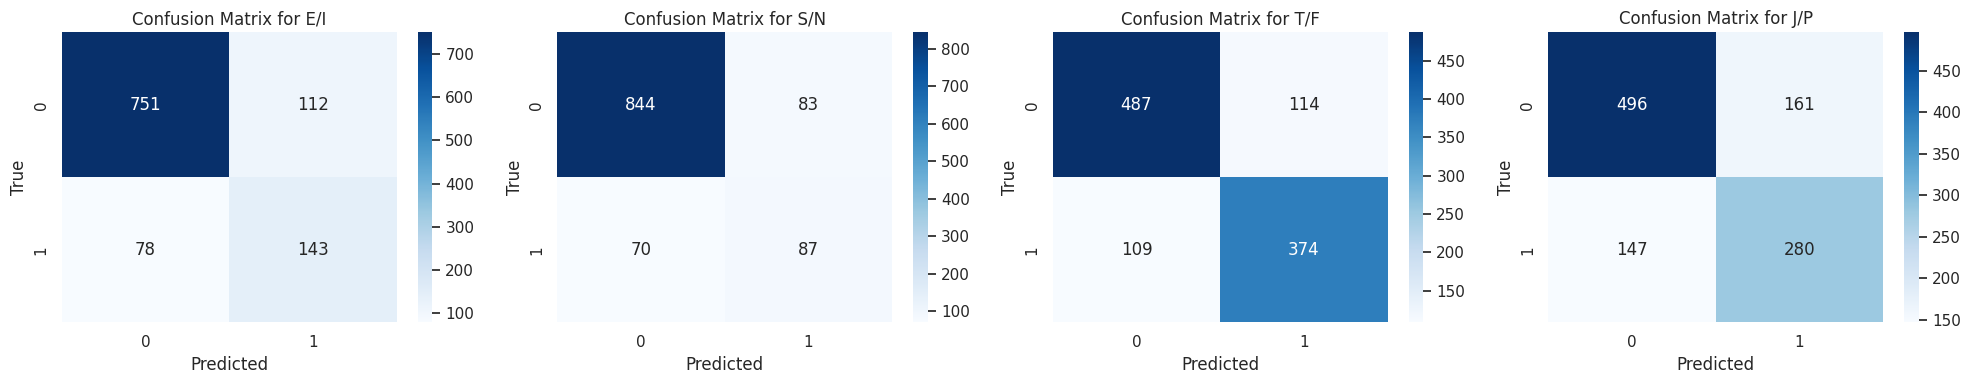

In [20]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for input_ids, attention_mask, labels in tqdm(val_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

print("\nClassification Report (Validation Set):\n")
print(classification_report(np.array(y_true), np.array(y_pred),
                            target_names=["E/I", "S/N", "T/F", "J/P"],
                            zero_division=0))

# Confusion Matrix
conf_matrices = multilabel_confusion_matrix(y_true, y_pred)
labels = ["E/I", "S/N", "T/F", "J/P"]
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for i in range(4):
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f"Confusion Matrix for {labels[i]}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")
plt.tight_layout()
plt.show()


In [21]:
# Predict MBTI traits for a single input text
def predict_mbti(text):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=256)
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)
        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()
        binary_output = [1 if p >= 0.5 else 0 for p in probs]
        mbti_traits = ["E" if binary_output[0] else "I",
                       "S" if binary_output[1] else "N",
                       "T" if binary_output[2] else "F",
                       "J" if binary_output[3] else "P"]
        return "".join(mbti_traits), probs

example_text = "I love exploring new places and meeting people. I tend to be logical and like to make decisions quickly."
pred_type, confidence = predict_mbti(example_text)
print(f"Predicted MBTI type: {pred_type}")
print(f"Trait confidences: {confidence}")


Predicted MBTI type: ESFP
Trait confidences: [0.8658906  0.91082776 0.3146488  0.16639657]
